# CA3 model

This notebook is for building out the CA3 model as previous implementation doesn't work.

Formula is:
$$
min_{\vec{w}_{x_1}, \vec{w}_{x_2}, \vec{w}_a, \vec{w}_b} \left( -\vec{w}_{x_1}^T S_{xa} \vec{w}_a - \vec{w}_{x_2}^T S_{xb} \vec{w}_b + \sum_{i \in \{x_1, x_2, a, b\}} \frac{1}{2} \lambda_i \left( \vec{w}_i^T S_{ii} \vec{w}_i - 1 \right) + \theta_{rr}(\vec{w}_{x_1}, \vec{w}_{x_2}) \right)
$$


In [1]:
from gemmr.generative_model import GEMMR
from gemmr.estimators import SVDCCA
import numpy as np
from scipy.optimize import minimize
import itertools
import scipy.stats
from sklearn.cross_decomposition import CCA

## Generate some data

import numpy as np
from sklearn.cross_decomposition import CCA

np.random.seed(0)

n_samples = 200
n_features_x = 10
n_features_y = 8

# Latent variables (shared source of variance)
latent = np.random.randn(n_samples, 3)

# Mix latent variables with some noise
behavioural_data_study1 = latent @ np.random.randn(3, n_features_x) + 0.1 * np.random.randn(n_samples, n_features_x)
imging_data_study1 = latent @ np.random.randn(3, n_features_y) + 0.1 * np.random.randn(n_samples, n_features_y)


In [2]:
model_definition = GEMMR('cca', wx=2, wy=50, r_between=0.3)
behavioural_data_study1, imging_data_study1 = model_definition.generate_data(n=200)
behavioural_data_study2, imging_data_study2 = model_definition.generate_data(n=190)
study1 = (imging_data_study1, behavioural_data_study1) 
study2 = (imging_data_study2, behavioural_data_study2)

In [3]:
test= SVDCCA().fit(imging_data_study1, behavioural_data_study1)
test.corrs_

array([0.58443793])

In [4]:
optimum = test.transform(imging_data_study1, behavioural_data_study1)
optimum

(array([[ 0.23413015],
        [-0.11706291],
        [ 0.16420848],
        [-0.06933801],
        [ 0.03204883],
        [-0.23415335],
        [ 0.27490088],
        [-0.12359661],
        [ 0.05333989],
        [-0.12522363],
        [ 0.21033221],
        [ 0.15454009],
        [-0.14103254],
        [-0.18313439],
        [-0.04284844],
        [-0.17617693],
        [ 0.13937902],
        [ 0.20611246],
        [ 0.06223303],
        [-0.33303882],
        [-0.06479431],
        [-0.1341867 ],
        [ 0.56784515],
        [-0.01649121],
        [ 0.03142534],
        [-0.3943707 ],
        [ 0.33662634],
        [-0.33768806],
        [ 0.29714305],
        [ 0.08064733],
        [-0.05574201],
        [ 0.08992479],
        [ 0.15708192],
        [ 0.07465376],
        [-0.14606527],
        [-0.16631399],
        [ 0.06499586],
        [ 0.44462718],
        [-0.40452233],
        [-0.21443285],
        [ 0.0614922 ],
        [-0.08090598],
        [ 0.32804573],
        [-0

In [5]:
r2= []
for val in range(imging_data_study1.shape[1]):
    corr = scipy.stats.pearsonr(behavioural_data_study1[:, 1], imging_data_study1[:, val])[0]
    r2.append(corr)
np.mean(r2)

np.float64(0.001198322127835738)

## Step 1: Covariance matrix

In [6]:
def mean_center(data: np.ndarray) -> np.ndarray:
    """
    Function to demean data.

    Parmeteres
    ----------
    data: np.ndarray
        data to demean

    Returns
    -------
    np.ndarray: array
        demeaned data
    """
    return data - data.mean(axis=0)

In [7]:
def cross_cov(matrix_1: np.ndarray, matrix_2: np.ndarray) -> np.ndarray:
    """
    Function to calculate 
    covariance matrix

    Parameters
    ----------
    matrix_1: np.ndarray
        A matrix tht should 
        correspond to subject by 
        features
    matrix_2: np.ndarray
        A matrix that should 
        correspond to features by
        feautres 

    Returns
    -------
    np.ndarray: array
        array of cross covariance matrix
    """
    return (matrix_1.T @ matrix_2) / matrix_1.shape[0] 

In [8]:
def data_able_to_process(study_pair: tuple, behav_data: np.ndarray, img_data: np.ndarray) -> bool:
    """
    Function to check that data
    is in correct format to be processed

    Parameters
    ----------
     study_pair: tuple, 
         tuple of behavioural data 
         and imging data
     behav_data: np.ndarray
         array of behav_data 
     img_data: np.ndarray
         array of img_data
    
    Returns
    -------
    bool: boolean
        bool of if failed or not
    """
    if not isinstance(study_pair, (tuple, list)) or len(study_pair) != 2:
        print("Given argument isn't a pair of datasets")
        return False
    if not isinstance(behav_data, np.ndarray) or not isinstance(img_data, np.ndarray):
        print("Data provided isn't a numpy array")
        return False
    if behav_data.shape[0] == 0 or img_data.shape[0] == 0 or behav_data.shape[0] != img_data.shape[0]:
        print(f"Mismatch between ({behav_data.shape[0]} and {img_data.shape[0]})")

    return True

In [104]:
def calculate_covariance_matricies(*study_pairs) -> dict:
    """
    Calculates covariance matrices and auto covariance
    matricies

    Parameters
    ----------
    study_pairs: tuple
        a tuple or list containing two numpy arrays:
        (behavioural_data, imaging_data).
        Assumes data is (subjects x features).

    Returns
    -------
    covariance_results: dict
        dictionary of covariance and auto-covariance matrices

    """
    covariance_results = {}
    for idx, study_pair in enumerate(study_pairs):
        img_data, behav_data  = study_pair
        if not data_able_to_process(study_pair, behav_data, img_data):
            continue
        behav_data = mean_center(behav_data)
        img_data = mean_center(img_data)
        study_num = idx + 1
        try:
            covariance_results[f"s_behav{study_num}_behav{study_num}"] = cross_cov(behav_data, behav_data)
            covariance_results[f"s_img{study_num}_img{study_num}"] = cross_cov(img_data, img_data)
            covariance_results[f"s_img{study_num}_behav{study_num}"] = cross_cov(img_data, behav_data)

        except Exception as e:
            print(f"Error calculating covariances for Study {study_num}: {e}")
            return None
    return covariance_results

In [125]:
covariance_mat = calculate_covariance_matricies(study1, study2)

In [116]:
s_x1a = cross_cov(behavioural_data_study1, imging_data_study1)
s_x2b = cross_cov(behavioural_data_study2, imging_data_study2)
s_x1x1 = cross_cov(behavioural_data_study1, behavioural_data_study1)
s_x2x2 = cross_cov(behavioural_data_study2, behavioural_data_study2)
s_aa = cross_cov(imging_data_study1, imging_data_study1)
s_bb = cross_cov(imging_data_study2, imging_data_study2)

## Step 2. Intialization of weights 

In [12]:
def weight_intialization(*weights) -> np.ndarray:
    """
    Define a set of random starting 
    weights
    
    Parameters
    ----------
    weights: tuple(int)
        tuple of set amount
        of int values
    
    Returns
    -------
    np.ndarrray
        array of numpy values
    """
    return np.random.randn(sum(weights))

In [13]:
dim = {
  '1': behavioural_data_study1.shape[1], 
   '2': behavioural_data_study2.shape[1],
    '3': imging_data_study1.shape[1],
    '4': imging_data_study2.shape[1]
 }

In [14]:
weights_0 = weight_intialization(
    behavioural_data_study1.shape[1], 
    behavioural_data_study2.shape[1],
    imging_data_study1.shape[1],
    imging_data_study2.shape[1]
    )

## Step 3. Objective function

In [15]:
dx1_shape = s_x1x1.shape[0]
dx2_shape = s_x2x2.shape[0]
da_shape = s_aa.shape[0]
db_shape = s_bb.shape[0]
dx_shape = dx1_shape + dx2_shape
dac_shape =  dx_shape + da_shape

def get_dimensions(s_x1x1, s_x2x2, s_aa):
    dx1_shape = s_x1x1.shape[0]
    dx2_shape = s_x2x2.shape[0]
    da_shape = s_aa.shape[0]
    dx_shape =  dx1_shape + dx2_shape
    return {
        'dx1_shape': dx1_shape,
        'dx_shape' : dx_shape,
        'dac_shape':  dx_shape + da_shape
    }

def get_weights(weight_array, dx1_shape, dx_shape, dac_shape):
    return {
        "wx1": weight_array[:dx1_shape],
        "wx2": weight_array[dx1_shape:dx_shape],
        "wa": weight_array[dx_shape:dac_shape],
        "wb": weight_array[dac_shape:]
    }


In [138]:
def cross_cov_term(weight_beh, cov_mat, weight_img):
    return -weight_img.T @ (cov_mat @ weight_beh)

In [139]:
def regularization_term(weight, cov_mat):
    return 0.5 * 1.0 * (weight.T @ (cov_mat @ weight) - 1)

In [ ]:
def dissimilarity_penality(theta_r, img_weight1, img_weight2):
    return theta_r * 0.5 * np.sum((img_weight1 - img_weight2) ** 2)


In [19]:
def objective_function(weights, s_x1a, s_x2b, s_x1x1, s_x2x2, s_aa, s_bb, theta_r):
    dimensions = get_dimensions(s_x1x1, s_x2x2, s_aa)
    weights = get_weights(
            weights, 
            dimensions['dx1_shape'], 
            dimensions['dx_shape'], 
            dimensions['dac_shape'])
    term1 = cross_cov_term(weights['wx1'],s_x1a, weights['wa'])
    term2 = cross_cov_term(weights['wx2'],s_x2b, weights['wb'])
    reg_x1 = regularization_term(weights['wx1'], s_x1x1)
    reg_x2 = regularization_term(weights['wx2'], s_x2x2)
    reg_a = regularization_term(weights['wa'], s_aa)
    reg_b = regularization_term(weights['wb'], s_bb)
    theta_r = dissimilarity_penality(theta_r, weights['wa'], weights['wb'])
    return term1 + term2 + reg_x1 + reg_x2 + reg_a + reg_b + theta_r


## Step 4: Minimise

In [20]:
best_loss = float('inf')
optimal_theta_r = None
optimium_model = None

for theta_r in np.logspace(-3, 2, 10):
    weights_0 = weight_intialization(
        behavioural_data_study1.shape[1], 
        behavioural_data_study2.shape[1],
        imging_data_study1.shape[1],
        imging_data_study2.shape[1])  # re-init each time
    res = minimize(
        objective_function,
        weights_0,
        args=(s_x1a, s_x2b, s_x1x1, s_x2x2, s_aa, s_bb, theta_r),
        method='L-BFGS-B'
    )
    if res.status !=0:
        print(res.status)
        continue


    if res.fun < best_loss:
        best_loss = res.fun
        best_theta_r = theta_r
        optimium_model = res

print(f"Best θ_r: {best_theta_r}")
print(f"Best loss: {best_loss}")

1
1
1
Best θ_r: 0.046415888336127795
Best loss: -1.9999999921047418


In [22]:
dimensions = get_dimensions(s_x1x1, s_x2x2, s_aa)
weights = get_weights(optimium_model.x,
            dimensions['dx1_shape'], 
            dimensions['dx_shape'], 
            dimensions['dac_shape'])

In [23]:
# Get projections (scores)
scores_x1 = behavioural_data_study1 @ weights['wx1']
scores_x2 = behavioural_data_study2 @ weights['wx2']
scores_a  = imging_data_study1 @ weights['wa']
scores_b  = imging_data_study2 @ weights['wb']


In [24]:
display(np.corrcoef(scores_x1, scores_a)[0, 1])
display(np.corrcoef(scores_x2, scores_b)[0, 1])
display(np.linalg.norm(weights['wa'] - weights['wb']))

np.float64(0.11538425261898907)

np.float64(0.07889484464506155)

np.float64(0.00014508777456870848)

## Putting it all together

In [ ]:
import numpy as np

class GridSearchCA3:
    def __init__(self, l2_values, theta=0, tol=1e-6, maxiter=500, verbose=False):
        """
        Custom grid search to find the best l2 value for the CA3 model.

        Parameters
        ----------
        l2_values : list of float
            The l2 regularization parameters to search over.
        theta : float
            The dissimilarity regularization parameter (shared across all models).
        tol : float
            Tolerance for optimization.
        maxiter : int
            Maximum number of optimization iterations.
        verbose : bool
            If True, print progress during search.
        """
        self.l2_values = l2_values
        self.theta = theta
        self.tol = tol
        self.maxiter = maxiter
        self.verbose = verbose
        self.best_model_ = None
        self.best_score_ = -np.inf
        self.best_l2_ = None
        self.all_results_ = []

    def fit(self, *data_sets):
        """
        Fit CA3 models with each l2 value and track the one with best score.
        """
        for l2 in self.l2_values:
            model = CA3(l2=l2, theta=self.theta, tol=self.tol, maxiter=self.maxiter)
            model.fit(*data_sets)
            score = model._score(*data_sets)

            self.all_results_.append((l2, score))

            if self.verbose:
                print(f"l2: {l2:.4f}, score: {score:.4f}")

            if score > self.best_score_:
                self.best_score_ = score
                self.best_model_ = model
                self.best_l2_ = l2

        if self.verbose:
            print(f"Best l2: {self.best_l2_:.4f}, Best score: {self.best_score_:.4f}")

    def get_best_model(self):
        return self.best_model_

    def get_best_l2(self):
        return self.best_l2_

    def get_all_results(self):
        return self.all_results_


In [231]:
class CA3:
    """
    CA3 class. 
    A class to do CA3 

    Usage
    -----
    ca3 = CA3(l2=0.5, theta=1)
    ca3.fit(study1, study2)
    transformed = ca3.transform(study1, study2)
    """
    def __init__(self, l2: float=1, theta: float=0, tol=1e-6, maxiter=500, normalise_weights=True):
        self.l2_ = l2
        self.theta_ = theta
        self.intial_weights_ = None
        self.dims_ = []
        self.best_loss = float('inf')
        self.weights_ = None
        self.covariances_ = {}
        self.tol_ = tol
        self.maxiter_ = maxiter
        self.normalise_weights = normalise_weights

    def fit(self, *data_sets):
        self._calculate_covariance_matricies(*data_sets)
        self._get_dimensions(*data_sets)
        self._weight_intialization()
        self._optimise()

    def transform(self, *data_sets):
        assert self.weights_ is not None, "Model must be fitted before transfomed can be called."
        assert len(data_sets) == len(self.dims_), "Model fitted with different number of datasets."
        
        scores = {}
        correlations = {}

        count = 0
        for (img_data, beh_data), (wx, wb) in zip(data_sets, self.weights_):
            imging_projections = img_data @ wx
            beh_projections = beh_data @ wb
            if self.normalise_weights:
                imging_projections = (imging_projections - np.mean(imging_projections)) / np.std(imging_projections, ddof=1)
                beh_projections = (beh_projections - np.mean(beh_projections)) / np.std(beh_projections, ddof=1)
                
            scores[f'study{count}'] = [imging_projections, beh_projections]
            corr = np.array([np.corrcoef(imging_projections, beh_projections)[0, 1]])
            correlations[f'study{count}'] = corr
            count += 1
    
        return {
              "correlations": correlations, 
              "projections": scores
        }
    
    def fit_transform(self, *data_sets):
        self.fit(*data_sets)
        return self.transform(*data_sets)
    
    def _weight_intialization(self) -> np.ndarray:
        """
        Define a set of random starting 
        weights
        
        Parameters
        ----------
        weights: tuple(int)
            tuple of set amount
            of int values
        
        Returns
        -------
        np.ndarrray
            array of numpy values
        """ 
        init_weights = []

        for idx, _ in enumerate(self.dims_):
            s_xb = self.covariances_[f"s_img{idx+1}_behav{idx+1}"]
    
            # Perform SVD on the cross-covariance matrix
            try:
                U, _, Vt = np.linalg.svd(s_xb, full_matrices=False)
            except np.linalg.LinAlgError as e:
                raise RuntimeError(f"SVD failed for dataset {idx+1}: {e}")
    
            # First left/right singular vectors as initial directions
            wx = U[:, 0]
            wb = Vt.T[:, 0]
    
            # Normalize to unit norm under their autocovariance
            s_xx = self.covariances_[f"s_img{idx+1}_img{idx+1}"]
            s_bb = self.covariances_[f"s_behav{idx+1}_behav{idx+1}"]
    
            wx = wx / np.sqrt(wx.T @ s_xx @ wx)
            wb = wb / np.sqrt(wb.T @ s_bb @ wb)
    
            init_weights.extend(wx)
            init_weights.extend(wb)
    
        self.intial_weights_ = np.array(init_weights)

    def _calculate_covariance_matricies(self, *data_sets) -> dict:
        """
        Calculates covariance matrices and auto covariance
        matricies
    
        Parameters
        ----------
        study_pairs: tuple
            a tuple or list containing two numpy arrays:
            (behavioural_data, imaging_data).
            Assumes data is (subjects x features).
    
        Returns
        -------
        covariance_results: dict
            dictionary of covariance and auto-covariance matrices
    
        """
        for idx, study_pair in enumerate(data_sets):
            img_data, behav_data  = study_pair
            if not self._data_able_to_process(study_pair, behav_data, img_data):
                continue
            behav_data = self._mean_center(behav_data)
            img_data = self._mean_center(img_data)
            study_num = idx + 1
            try:
                self.covariances_[f"s_behav{study_num}_behav{study_num}"] = self._create_covariance_matrix(behav_data, behav_data)
                self.covariances_[f"s_img{study_num}_img{study_num}"] = self._create_covariance_matrix(img_data, img_data)
                self.covariances_[f"s_img{study_num}_behav{study_num}"] = self._create_covariance_matrix(img_data, behav_data)
    
            except Exception as e:
                print(f"Error calculating covariances for Study {study_num}: {e}")

    def _data_able_to_process(self, study_pair: tuple, behav_data: np.ndarray, img_data: np.ndarray) -> bool:
        """
        Function to check that data
        is in correct format to be processed
    
        Parameters
        ----------
         study_pair: tuple, 
             tuple of behavioural data 
             and imging data
         behav_data: np.ndarray
             array of behav_data 
         img_data: np.ndarray
             array of img_data
        
        Returns
        -------
        bool: boolean
            bool of if failed or not
        """
        if not isinstance(study_pair, (tuple, list)) or len(study_pair) != 2:
            print("Given argument isn't a pair of datasets")
            return False
        if not isinstance(behav_data, np.ndarray) or not isinstance(img_data, np.ndarray):
            print("Data provided isn't a numpy array")
            return False
        if behav_data.shape[0] == 0 or img_data.shape[0] == 0 or behav_data.shape[0] != img_data.shape[0]:
            print(f"Mismatch between ({behav_data.shape[0]} and {img_data.shape[0]})")
    
        return True
            
    def _optimise(self):
        model = minimize(
            self._objective_function,
            self.intial_weights_,
            options={'gtol': self.tol_, "maxiter": self.maxiter_},
            args=(self.covariances_, self.theta_, self.l2_),
        )
        self.best_loss = model.fun
        self.weights_ = self._split_weights(model.x)

    
    def _get_dimensions(self, *data_sets):
        self.dims_ = [(behav.shape[1], img.shape[1]) for behav, img in data_sets]
    
    def _split_weights(self, w):
        """
        Splits the flat weight vector w into individual vectors
        for each behavioural and imaging dataset.
        """
        offset = 0
        weights = []
        for img_dim, behav_dim in self.dims_:
            wx = w[offset:offset + img_dim]
            offset += img_dim  
            wb = w[offset:offset + behav_dim]
            offset += behav_dim
            weights.append((wx, wb))
        return weights 
    
    def _objective_function(self, weights, covariances, theta, l2):
        total_loss = 0
        weights_ = self._split_weights(weights)
        for idx, (wx, wb) in enumerate(weights_):
            s_xb = covariances[f"s_img{idx+1}_behav{idx+1}"]
            s_xx = covariances[f"s_img{idx+1}_img{idx+1}"]
            s_bb = covariances[f"s_behav{idx+1}_behav{idx+1}"]
            total_loss += self._cross_cov_term(wb, s_xb, wx) 
            total_loss += self._regularization_term(wx, s_xx, l2)
            total_loss += self._regularization_term(wb, s_bb, l2)
    
        # Similarity penalty across imaging weights
        if theta > 0 and len(weights_) > 1:
            for img_data in range(len(weights_)):
                for next_img_data in range(img_data + 1, len(weights_)):
                    total_loss += self._dissimilarity_penality(theta, weights_[img_data][0], weights_[next_img_data][0])
    
        return total_loss
    
    def _create_covariance_matrix(self, matrix_1: np.ndarray, matrix_2: np.ndarray) -> np.ndarray:
        """
        Function to calculate 
        covariance matrix
    
        Parameters
        ----------
        matrix_1: np.ndarray
            A matrix tht should 
            correspond to subject by 
            features
        matrix_2: np.ndarray
            A matrix that should 
            correspond to features by
            feautres 
    
        Returns
        -------
        np.ndarray: array
            array of cross covariance matrix
        """
        return (matrix_1.T @ matrix_2) / matrix_1.shape[0] 
    
    def _mean_center(self, data: np.ndarray) -> np.ndarray:
        """
        Function to demean data.
    
        Parmeteres
        ----------
        data: np.ndarray
            data to demean
    
        Returns
        -------
        np.ndarray: array
            demeaned data
        """
        dmean = data - data.mean(axis=0)
        std = data.std(axis=0, ddof=1)
        std[std == 0.0] = 1.0
        return dmean / std

    def _cross_cov_term(self, weight_beh, cov_mat, weight_img):
        return -weight_img.T @ (cov_mat @ weight_beh)

    def _regularization_term(self, weight, cov_mat, lambda_i):
        return 0.5 * lambda_i * (weight.T @ (cov_mat @ weight) - 1)

    def _dissimilarity_penality(self, theta_r, img_weight1, img_weight2):
        return theta_r * 0.5 * np.sum((img_weight1 - img_weight2) ** 2)
    
    def _score(self, *data_sets):
        """
        Returns the mean correlation across all datasets.

        This is used by GridSearchCV to evaluate model performance.
        """
        if self.weights_ is None:
            raise ValueError("Model must be fitted before scoring.")

        result = self.transform(*data_sets)
        correlations = result["correlations"]
        all_corrs = [corr[0] for corr in correlations.values()]
        return np.mean(all_corrs)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Assuming `data` is a list of tuples: [(img1, beh1), (img2, beh2), ...]
# Define a custom scorer if needed, but the `score` method should suffice

search = GridSearchCA3(l2_values=[0.01, 0.1, 1.0, 10.0], theta=0.5, verbose=True)
search.fit(study1)

best_model = search.get_best_model()
print("Best L2:", search.get_best_l2())
print("Best score:", search.best_score_)

l2: 0.0100, score: 0.4592
l2: 0.1000, score: 0.4614
l2: 1.0000, score: 0.1377
l2: 10.0000, score: 0.0029
Best l2: 0.1000, Best score: 0.4614
Best L2: 0.1
Best score: 0.4614104420916759


In [250]:
ca3 = CA3(l2=0.1)
ca3.fit(study1)
transfomed = ca3.transform(study1)

In [234]:
from sklearn.cross_decomposition import CCA

test_sck = CCA(n_components=1)
test_sck.fit(study1[0], study1[1])
X1_proj_cca, Y1_proj_cca = test_sck.transform(study1[0], study1[1])
sklearn_corr = np.corrcoef(X1_proj_cca.ravel(), Y1_proj_cca.ravel())[0,1]
print(f"Correlation from sklearn CCA: {sklearn_corr}")

Correlation from sklearn CCA: 0.5844376198244914


TtestResult(statistic=np.float64(-2.2825828859293656e-16), pvalue=np.float64(0.9999999999999998), df=np.float64(398.0))

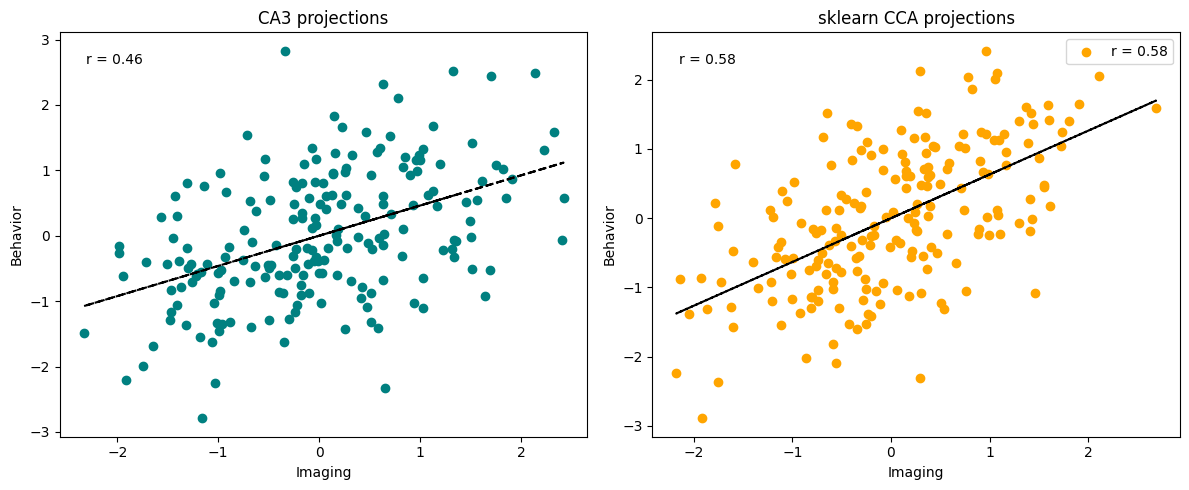

In [ ]:
import matplotlib.pyplot as plt

X1_proj_ca3, Y1_proj_ca3 = transfomed['projections']['study0']
display(scipy.stats.ttest_ind(X1_proj_ca3.flatten(), X1_proj_cca.flatten() ))
plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.scatter(X1_proj_ca3, Y1_proj_ca3, c='teal')
m, b = np.polyfit(X1_proj_ca3.flatten(), Y1_proj_ca3.flatten(), 1)
plt.plot(X1_proj_ca3, m*X1_proj_ca3 + b, color='black', linestyle='--')
plt.text(0.05, 0.95, f"r = {transfomed['correlations']['study0'][0]:.2f}", 
         transform=plt.gca().transAxes, va='top', ha='left')
plt.title("CA3 projections")
plt.xlabel("Imaging")
plt.ylabel("Behavior")

plt.subplot(1, 2, 2)
plt.scatter(X1_proj_cca, Y1_proj_cca, c='orange', label=f"r = {sklearn_corr:.2f}")
m, b = np.polyfit(X1_proj_cca.flatten(), Y1_proj_cca.flatten(), 1)
plt.plot(X1_proj_cca, m*X1_proj_cca + b, color='black', linestyle='--')
plt.text(0.05, 0.95, f"r = {sklearn_corr:.2f}", 
         transform=plt.gca().transAxes, va='top', ha='left')
plt.title("sklearn CCA projections")
plt.xlabel("Imaging")
plt.ylabel("Behavior")
plt.legend()
plt.tight_layout()
plt.show()